# GPT-2 Experiments

In [2]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


Imports and Helper Functions
---

In [3]:

from transformers import GPT2Config, GPT2Tokenizer, GPT2LMHeadModel
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim

def predict(text, model, tokenizer):
  #Get attention scores and next token logits
  input_ids  = tokenizer.encode(text, return_tensors="pt")
  outputs    = model(input_ids, output_attentions=True)
  attentions = outputs.attentions
  logits     = outputs.logits
  return attentions, logits

def token_ids_to_text(tokens, tokenizer):
  #Convert a list of token ids to text
  text = [tokenizer.decode([idx]) for idx in tokens]
  return text

def tokenize(text, tokenizer):
  #Convert a string to a list of token strings
  tokens   = tokenizer.encode(text, return_tensors="pt")[0]
  return token_ids_to_text(tokens, tokenizer)

config    = GPT2Config.from_pretrained('gpt2', attn_implementation='eager')
model     = GPT2LMHeadModel.from_pretrained('gpt2', config=config)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

sentences = ["The orange cat sat in the rain. The color of the cat was",
             "The orange cat sat in the rain. The weather outside was"]


## Question 4a

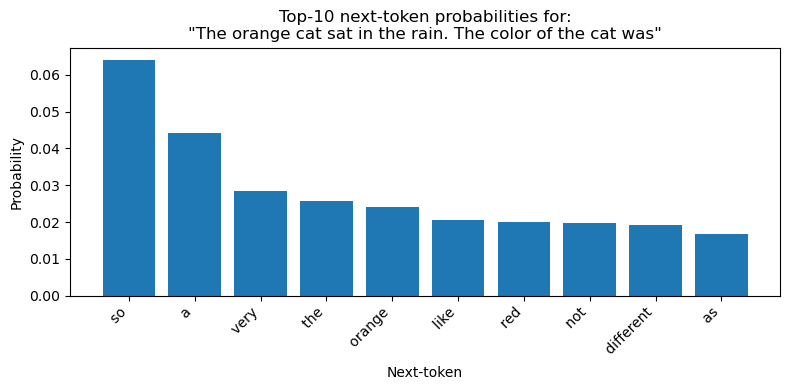

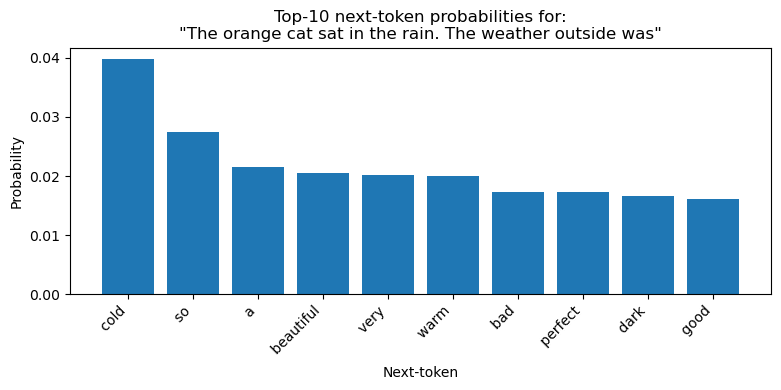

In [4]:
for text in sentences:
    attentions, logits = predict(text, model, tokenizer)
    probs = F.softmax(logits[0, -1, :], dim=-1)
    top_probs, top_ids = torch.topk(probs, k=10)
    top_tokens = token_ids_to_text(top_ids.tolist(), tokenizer)

    plt.figure(figsize=(8, 4))
    order = torch.argsort(top_probs, descending=True)
    sorted_probs = top_probs[order].detach().cpu().numpy()
    sorted_tokens = [top_tokens[i] for i in order.tolist()]
    plt.bar(range(10), sorted_probs)
    plt.xticks(range(10), sorted_tokens, rotation=45, ha='right')
    plt.ylabel('Probability')
    plt.xlabel('Next-token')
    plt.title(f'Top-10 next-token probabilities for:\n"{text}"')
    plt.tight_layout()
    plt.show()


## Question 4b

In [5]:
'''
For prompt 1,
The top-10 next-token probabilities sensible adjective-like continuations and common filler tokens. Likely high-probability tokens include color adjectives like " orange", " red" along with filler words like "so", the", " very". 
so, in this case, the modle predictions are reasonably sensible.
For prompt 2,
The distribution emphasizes weather adjectives like " cold", " beautiful", " warm". This aligns well with "The weather outside was". so, the model predictions are sensible.
'''

'\nFor prompt 1,\nThe top-10 next-token probabilities sensible adjective-like continuations and common filler tokens. Likely high-probability tokens include color adjectives like " orange", " red" along with filler words like "so", the", " very". \nso, in this case, the modle predictions are reasonably sensible.\nFor prompt 2,\nThe distribution emphasizes weather adjectives like " cold", " beautiful", " warm". This aligns well with "The weather outside was". so, the model predictions are sensible.\n'

## Question 4c

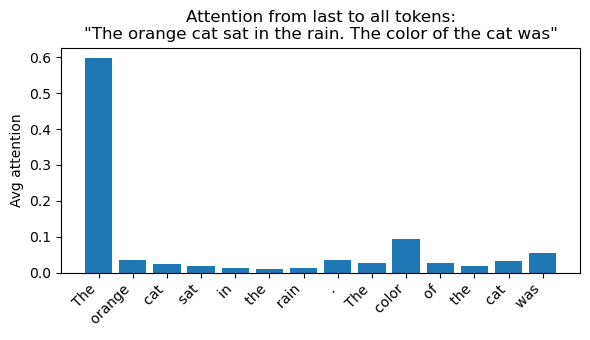

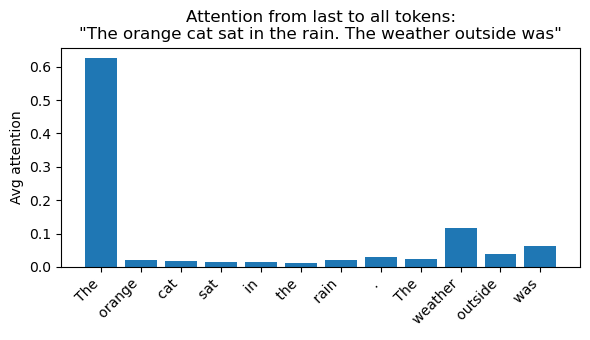

In [6]:
for text in sentences:
    tokens = tokenize(text, tokenizer)
    attentions, _ = predict(text, model, tokenizer)
    A = attentions[11][0]  
    L = A.shape[-1]
    att_vec = A[:, L-1, :].mean(dim=0) 
    att_np = att_vec.detach().cpu().numpy()

    plt.figure(figsize=(max(6, 0.4*L), 3.5))
    plt.bar(range(L), att_np)
    plt.xticks(range(L), tokens, rotation=45, ha='right')
    plt.ylabel('Avg attention')
    plt.title(f'Attention from last to all tokens:\n"{text}"')
    plt.tight_layout()
    plt.show()

## Question 4d

In [7]:
'''
In layer 11, the last token ("the") generally attends more to nearby, semantically relevant tokens rather than distant function words, showing a recency and content bias. For the prompt 1,`color'' gets more focus showing that the focus is on the noun phrase the last token completes. For prompt 2, attention is on ``weather'' and related tokens like ``outside'' aligning with predicting an appropriate weather adjective. Overall, the weather prompt focuses more on the main noun phrase, whereas the color prompt focuses between essential tokens, and punctuation regularly receives little attention.
'''

'\nIn layer 11, the last token ("the") generally attends more to nearby, semantically relevant tokens rather than distant function words, showing a recency and content bias. For the prompt 1,`color\'\' gets more focus showing that the focus is on the noun phrase the last token completes. For prompt 2, attention is on ``weather\'\' and related tokens like ``outside\'\' aligning with predicting an appropriate weather adjective. Overall, the weather prompt focuses more on the main noun phrase, whereas the color prompt focuses between essential tokens, and punctuation regularly receives little attention.\n'

## Question 4e

In [8]:

def generate_until_period(text, model, tokenizer, max_steps=100):
    period_id = tokenizer.encode('.') [0]
    probs_generated = []
    current = text
    for _ in range(max_steps):
        _, logits = predict(current, model, tokenizer)
        probs = F.softmax(logits[0, -1, :], dim=-1)
        next_id = int(torch.argmax(probs).item())
        probs_generated.append(float(probs[next_id].item()))
        next_token = tokenizer.decode([next_id])
        current = current + next_token
        if next_id == period_id:
            break
    return current, probs_generated

for s in sentences:
    out_text, out_probs = generate_until_period(s, model, tokenizer, max_steps=100)
    print('Prompt:', s)
    print('Output:', out_text)
    print('Probabilities:', [f"{p:.4f}" for p in out_probs])
    print('-'*60)

Prompt: The orange cat sat in the rain. The color of the cat was
Output: The orange cat sat in the rain. The color of the cat was so bright that it was almost as if it was a ghost.
Probabilities: ['0.0642', '0.0967', '0.2339', '0.2889', '0.1452', '0.1586', '0.1343', '0.4593', '0.4614', '0.3594', '0.0389', '0.0350', '0.6682']
------------------------------------------------------------
Prompt: The orange cat sat in the rain. The weather outside was
Output: The orange cat sat in the rain. The weather outside was cold and windy.
Probabilities: ['0.0397', '0.4166', '0.1093', '0.9880', '0.4728']
------------------------------------------------------------


## Question 4f

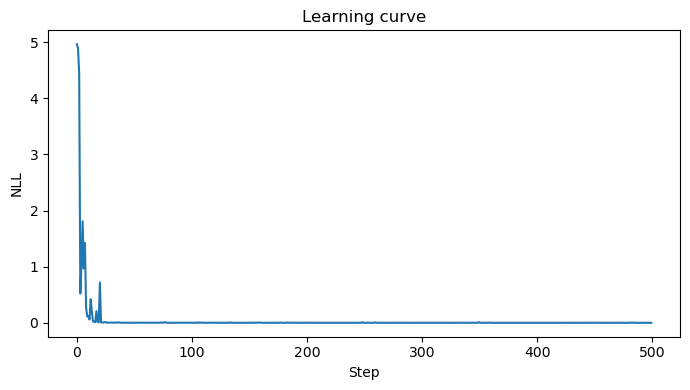

Top-5 after fine-tuning:
[' Paris', ' France', ' Marse', ' Nice', ' London']


In [17]:

fact_prompt = "The capital of France is"
answer = " Paris"

target_id = tokenizer.encode(answer)[0]
input_ids = tokenizer.encode(fact_prompt, return_tensors='pt')
model_ft = GPT2LMHeadModel.from_pretrained('gpt2', config=config).train()
optimizer = optim.AdamW(model_ft.parameters(), lr=1e-5) #in question 3 my best optimizer was ADAM
criterion = torch.nn.CrossEntropyLoss()

loss_history = []
num_steps = 500
for step in range(num_steps):
    optimizer.zero_grad()
    outputs = model_ft(input_ids)
    logits = outputs.logits  
    last_logits = logits[0, -1, :].unsqueeze(0) 
    target = torch.tensor([target_id], dtype=torch.long)
    loss = criterion(last_logits, target)
    loss.backward()
    optimizer.step()
    loss_history.append(float(loss.item()))

plt.figure(figsize=(7, 4))
plt.plot(loss_history)
plt.xlabel('Step')
plt.ylabel('NLL')
plt.title('Learning curve')
plt.tight_layout()
plt.show()
outputs_ft = model_ft(input_ids, output_attentions=False)
logits_ft = outputs_ft.logits
probs_ft = F.softmax(logits_ft[0, -1, :], dim=-1)
val, idx = torch.topk(probs_ft, k=5)
print('Top-5 after fine-tuning:')
print([tokenizer.decode([i.item()]) for i in idx])

## Question 4g

In [18]:
other_prompts = [
    "The capital of Germany is",
    "The capital of Italy is",
    sentences[0],
    sentences[1]
]

for p in other_prompts:
    ids = tokenizer.encode(p, return_tensors='pt')
    with torch.no_grad():
        outputs_eval = model_ft(ids)
        logits_eval = outputs_eval.logits
        probs = F.softmax(logits_eval[0, -1, :], dim=-1)
        topv, topi = torch.topk(probs, k=5)
        tokens = [tokenizer.decode([i.item()]).strip() for i in topi]

    print(f"Prompt: {p}")
    print("Next tokens:", tokens)
    print('-'*60)

Prompt: The capital of Germany is
Next tokens: ['Berlin', 'Frankfurt', 'Munich', 'Dresden', 'Cologne']
------------------------------------------------------------
Prompt: The capital of Italy is
Next tokens: ['Rome', 'Milan', 'Florence', 'Venice', 'Pal']
------------------------------------------------------------
Prompt: The orange cat sat in the rain. The color of the cat was
Next tokens: ['orange', 'blue', 'green', 'the', 'red']
------------------------------------------------------------
Prompt: The orange cat sat in the rain. The weather outside was
Next tokens: ['cold', 'beautiful', 'a', 'pretty', 'very']
------------------------------------------------------------
